In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('fivethirtyeight')

In [2]:
from datetime import datetime

df = pd.read_csv('../data/btcusdt.csv', index_col=False)
df['Opentime'] = df['Opentime'].apply(lambda x: datetime.fromisoformat(x))
del df['Ignore']    # remove unused ignored column

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Opentime            2000 non-null   datetime64[ns]
 1   Open                2000 non-null   float64       
 2   High                2000 non-null   float64       
 3   Low                 2000 non-null   float64       
 4   Close               2000 non-null   float64       
 5   Volume              2000 non-null   float64       
 6   Closetime           2000 non-null   int64         
 7   Quote asset volume  2000 non-null   float64       
 8   Number of trades    2000 non-null   int64         
 9   Taker by base       2000 non-null   float64       
 10  Taker buy quote     2000 non-null   float64       
dtypes: datetime64[ns](1), float64(8), int64(2)
memory usage: 172.0 KB


In [3]:
import plotly.graph_objects as go

fig = go.Figure(data=[
    go.Candlestick(
        x=df['Opentime'],
        open=df['Open'],
        high=df['High'],
        low=df['Low'],
        close=df['Close']
    )]
)
fig.show()

We hence compute the log returns on the closing price of the candlestick.

In [4]:
df['log_returns'] = np.log(df['Close'] / df['Close'].shift(1))
df.head()

,Opentime,Open,High,Low,Close,Volume,Closetime,Quote asset volume,Number of trades,Taker by base,Taker buy quote,log_returns
0,2021-11-14 14:42:00,64737.41,64764.34,64734.39,64742.59,7.53891,1636872179999,488117.410756,473,4.92262,318706.231661,NaN
1,2021-11-14 14:43:00,64742.59,64759.99,64737.41,64745.28,5.60107,1636872239999,362624.929911,371,2.75897,178622.330107,0.000042
2,2021-11-14 14:44:00,64745.27,64758.49,64737.41,64737.42,7.08672,1636872299999,458837.477987,360,0.90938,58881.772055,-0.000121
3,2021-11-14 14:45:00,64737.42,64787.41,64712.90,64787.41,13.42830,1636872359999,869293.539069,471,4.77677,309254.098798,0.000772
4,2021-11-14 14:46:00,64783.35,64824.61,64781.80,64791.62,9.11735,1636872419999,590831.661327,464,4.64922,301269.878849,0.000065


In [5]:
_NUM_OF_LAGS = 5

def generate_lags(data):
    global cols
    cols = []
    for lag in range(1, _NUM_OF_LAGS + 1):
        if 'log_returns' in data:
            col = 'lag_{}'.format(lag)
            data[col] = data['log_returns'].shift(lag)
            cols.append(col)
    print(cols)

In [6]:
generate_lags(df)

['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5']


<AxesSubplot:xlabel='lag_1', ylabel='lag_2'>

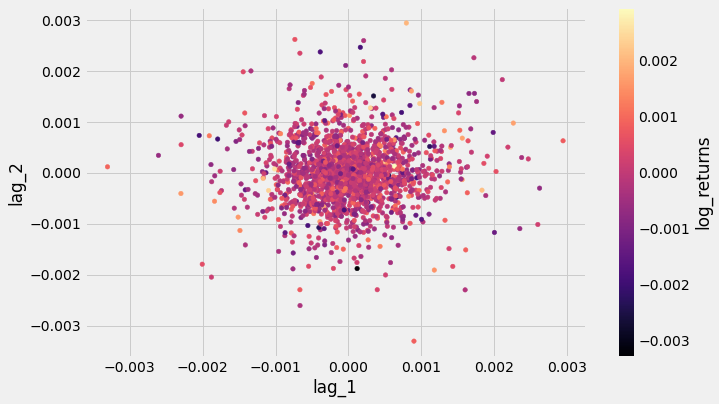

In [7]:
df.dropna(inplace=True)
df.plot.scatter(x='lag_1', y='lag_2', c='log_returns',
    cmap='magma', figsize=(10,6), colorbar=True)

In [8]:
df['direction'] = np.sign(df['log_returns']).astype(int)
df.head()

,Opentime,Open,High,Low,Close,Volume,Closetime,Quote asset volume,Number of trades,Taker by base,Taker buy quote,log_returns,lag_1,lag_2,lag_3,lag_4,lag_5,direction
6,2021-11-14 14:48:00,64795.95,64861.27,64794.51,64858.92,68.68362,1636872539999,4.450970e+06,498,63.64453,4.124251e+06,0.000972,0.000067,0.000065,0.000772,-0.000121,0.000042,1
7,2021-11-14 14:49:00,64861.27,64865.50,64801.57,64811.50,12.73647,1636872599999,8.258760e+05,485,4.26183,2.763368e+05,-0.000731,0.000972,0.000067,0.000065,0.000772,-0.000121,-1
8,2021-11-14 14:50:00,64811.50,64815.84,64793.59,64809.28,6.94801,1636872659999,4.502491e+05,346,4.15608,2.693201e+05,-0.000034,-0.000731,0.000972,0.000067,0.000065,0.000772,-1
9,2021-11-14 14:51:00,64809.28,64823.99,64809.27,64819.98,3.18836,1636872719999,2.066662e+05,277,1.07414,6.962353e+04,0.000165,-0.000034,-0.000731,0.000972,0.000067,0.000065,1
10,2021-11-14 14:52:00,64819.99,64830.40,64819.98,64824.97,3.79430,1636872779999,2.459571e+05,301,1.00875,6.538956e+04,0.000077,0.000165,-0.000034,-0.000731,0.000972,0.000067,1


In [9]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()

In [10]:
df['pos_ols_1'] = model.fit(df[cols],
                    df['log_returns']).predict(df[cols])

In [11]:
df['pos_ols_2'] = model.fit(df[cols],
                    df['direction']).predict(df[cols])

In [12]:
df[['pos_ols_1', 'pos_ols_2']].head()

,pos_ols_1,pos_ols_2
6,-0.000020,-0.053858
7,0.000009,-0.008422
8,-0.000025,-0.056635
9,-0.000027,-0.025767
10,0.000008,0.025105


In [13]:
import plotly.express as px

fig = px.scatter_3d(df, x='lag_1', y='lag_2', z='log_returns', color='Close', symbol='direction')
fig.show()

The real value predictions are then transformed to directional values, either -1 or +1.

In [14]:
df[['pos_ols_1', 'pos_ols_2']] = np.where(df[['pos_ols_1', 'pos_ols_2']] > 0, 1, -1)

In [15]:
df['pos_ols_1'].value_counts()

-1    1134
 1     860
Name: pos_ols_1, dtype: int64

In [16]:
df['pos_ols_2'].value_counts()

-1    1331
 1     663
Name: pos_ols_2, dtype: int64

In [17]:
df['strat_ols_1'] = df['pos_ols_1'] * df['log_returns']
df['strat_ols_2'] = df['pos_ols_2'] * df['log_returns']

Now we can plot out the performance of BTC-USD and regression-based strategies over time.

<AxesSubplot:>

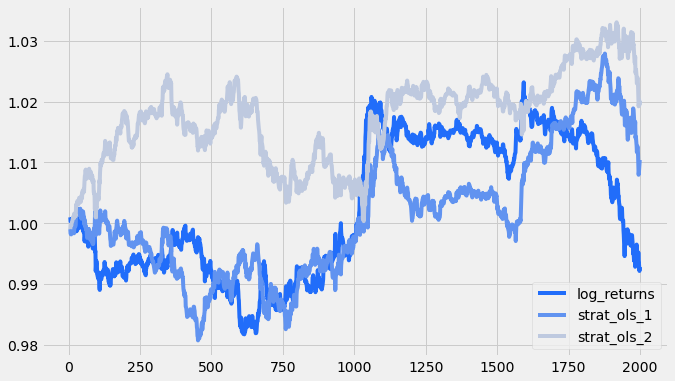

In [18]:
color_dict = {
    'log_returns': '#216DFA',
    'strat_ols_1': '#6193F0',
    'strat_ols_2': '#BEC9DF'
}
column_name = ['log_returns', 'strat_ols_1', 'strat_ols_2']

df[column_name].cumsum().apply(np.exp).plot(color=[color_dict.get(x) for x in column_name], figsize=(10,6))

In [19]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix

In [20]:
svm_model = SVC(C=2, kernel='linear', gamma='auto')

In [21]:
split = int(len(df) * 4 / 5)
split

1595

In [22]:
train = df.iloc[:split].copy()
train

,Opentime,Open,High,Low,Close,Volume,Closetime,Quote asset volume,Number of trades,Taker by base,...,lag_1,lag_2,lag_3,lag_4,lag_5,direction,pos_ols_1,pos_ols_2,strat_ols_1,strat_ols_2
6,2021-11-14 14:48:00,64795.95,64861.27,64794.51,64858.92,68.68362,1636872539999,4.450970e+06,498,63.64453,...,0.000067,0.000065,0.000772,-0.000121,0.000042,1,-1,-1,-0.000972,-0.000972
7,2021-11-14 14:49:00,64861.27,64865.50,64801.57,64811.50,12.73647,1636872599999,8.258760e+05,485,4.26183,...,0.000972,0.000067,0.000065,0.000772,-0.000121,-1,1,-1,-0.000731,0.000731
8,2021-11-14 14:50:00,64811.50,64815.84,64793.59,64809.28,6.94801,1636872659999,4.502491e+05,346,4.15608,...,-0.000731,0.000972,0.000067,0.000065,0.000772,-1,-1,-1,0.000034,0.000034
9,2021-11-14 14:51:00,64809.28,64823.99,64809.27,64819.98,3.18836,1636872719999,2.066662e+05,277,1.07414,...,-0.000034,-0.000731,0.000972,0.000067,0.000065,1,-1,-1,-0.000165,-0.000165
10,2021-11-14 14:52:00,64819.99,64830.40,64819.98,64824.97,3.79430,1636872779999,2.459571e+05,301,1.00875,...,0.000165,-0.000034,-0.000731,0.000972,0.000067,1,1,1,0.000077,0.000077
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1596,2021-11-15 17:17:00,66100.00,66172.87,66099.99,66149.69,32.48140,1636967879999,2.148146e+06,1203,20.58174,...,-0.000666,-0.002295,0.001114,0.000518,0.001102,1,-1,1,-0.000752,0.000752
1597,2021-11-15 17:18:00,66149.69,66169.72,66083.64,66114.52,25.44400,1636967939999,1.682498e+06,1072,9.40795,...,0.000752,-0.000666,-0.002295,0.001114,0.000518,-1,1,1,-0.000532,-0.000532
1598,2021-11-15 17:19:00,66114.51,66119.00,66063.95,66110.87,26.88352,1636967999999,1.776556e+06,1051,13.82249,...,-0.000532,0.000752,-0.000666,-0.002295,0.001114,-1,1,1,-0.000055,-0.000055
1599,2021-11-15 17:20:00,66110.86,66114.81,66038.32,66057.06,25.33008,1636968059999,1.673505e+06,984,10.85854,...,-0.000055,-0.000532,0.000752,-0.000666,-0.002295,-1,-1,-1,0.000814,0.000814


In [23]:
svm_model.fit(train[cols], train['direction'])

SVC(C=2, gamma='auto', kernel='linear')

In [24]:
accuracy_score(train['direction'], svm_model.predict(train[cols]))

0.5015673981191222

<AxesSubplot:>

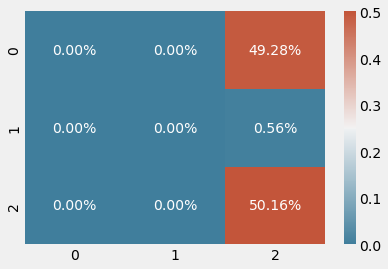

In [25]:
train_cfmatrix = confusion_matrix(train['direction'], svm_model.predict(train[cols]))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(train_cfmatrix / np.sum(train_cfmatrix), annot=True, fmt='.2%', cmap=cmap)

In [26]:
test = df.iloc[split:].copy()
test['position'] = svm_model.predict(test[cols])

In [27]:
accuracy_score(test['direction'], test['position'])

0.44110275689223055

<AxesSubplot:>

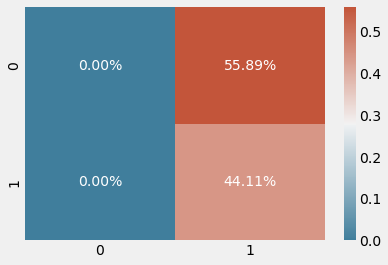

In [28]:
test_cfmatrix = confusion_matrix(test['direction'], test['position'])
sns.heatmap(test_cfmatrix / np.sum(test_cfmatrix), annot=True, fmt='.2%', cmap=cmap)

## References

- [Huiwen., Wenyang., Shanshan.(2021, March 31), Forecasting open-high-low-close data contained in candlestick chart](https://arxiv.org/pdf/2104.00581.pdf)
- [Gerald. M, (2019, April 25). Advanced candlesticks for machine learning(i): tick bars](https://towardsdatascience.com/advanced-candlesticks-for-machine-learning-i-tick-bars-a8b93728b4c5)